# 05 Using a drive cycle

PyBaMM provides a number of example drive cycles which can be read in from csv files. So we first change our current directory to the PyBaMM root directory in order to read it in.

In [1]:
!pip install -q git+https://github.com/pybamm-team/liionpack.git@main
import pybamm
import numpy as np
import os
import liionpack as lp
import pandas as pd
import matplotlib.pyplot as plt

os.chdir(pybamm.__path__[0] + "/..")

In [2]:
# import drive cycle from file
drive_cycle = pd.read_csv(
    "pybamm/input/drive_cycles/US06.csv", comment="#", header=None
).to_numpy()

Let's have a look at the drive cycle. The first column is the time stamp and the second is the current.

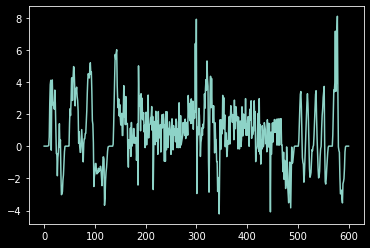

In [3]:
plt.figure()
plt.plot(drive_cycle[:, 0], drive_cycle[:, 1])

We can load an experiment using the drive cycle and give it a dictionary key and an operating condition to run it. N.B this is a new feature for PyBaMM and syntax may change so please condult the documentation and make sure you have the latest version of PyBaMM.

In [4]:
experiment = pybamm.Experiment(
    operating_conditions=["Run US06 (A)"],
    drive_cycles={"US06": drive_cycle},
    period="1 second",
)

Set up our pack using our favourite chemistry

In [5]:
netlist = lp.setup_circuit(Np=4, Ns=1, Rb=1e-4, Rc=1e-3, Ri=5e-2, V=4.0, I=1.0)

In [6]:
# Heat transfer coefficients
htc = np.ones(4) * 10
# PyBaMM parameters
chemistry = pybamm.parameter_sets.Chen2020
parameter_values = pybamm.ParameterValues(chemistry=chemistry)

In [7]:
# Solve pack
output_d = lp.solve(
    netlist=netlist,
    parameter_values=parameter_values,
    experiment=experiment,
    initial_soc=0.75,
)

Stepping simulation: 100%|███████████████████████████████████████████████████████████| 601/601 [00:05<00:00, 103.54it/s]


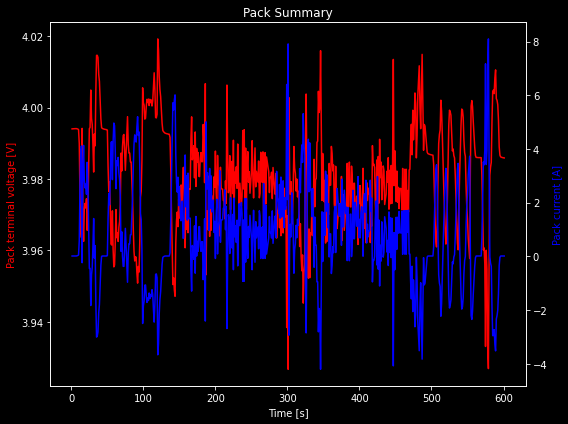

In [8]:
lp.plot_pack(output_d)

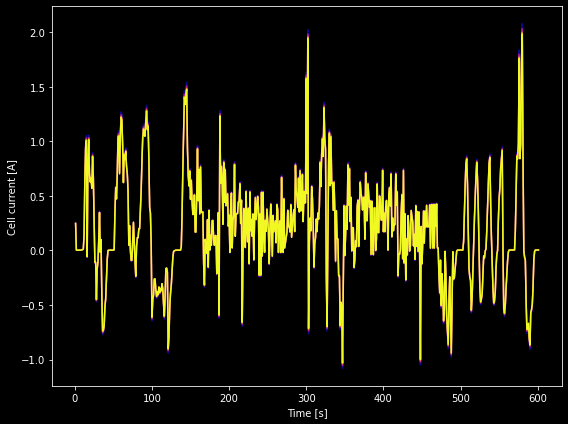

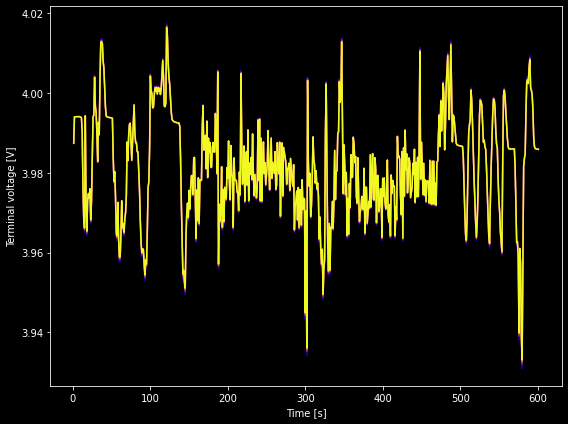

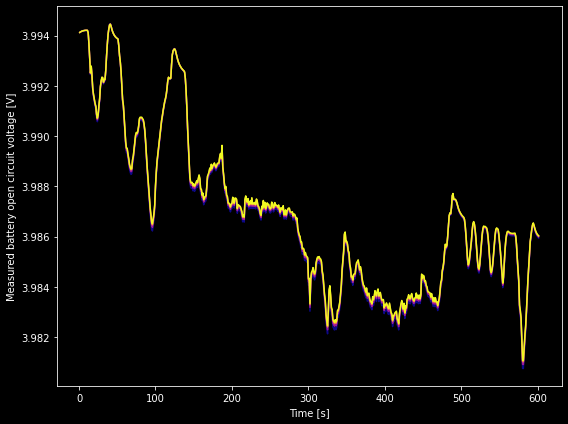

In [9]:
lp.plot_cells(output_d)

The mean current is:

In [10]:
I_mean = np.mean(drive_cycle[:, 1])
I_mean

0.8404807891846922

Let's see what the simulation looks like when we just discharge at the mean current for 600 s.

In [11]:
experiment = pybamm.Experiment(
    operating_conditions=["Discharge at 0.84 A for 601 s"], period="1 second"
)

In [12]:
# Solve pack
output_m = lp.solve(
    netlist=netlist,
    parameter_values=parameter_values,
    experiment=experiment,
    initial_soc=0.75,
)

Stepping simulation: 100%|███████████████████████████████████████████████████████████| 601/601 [00:05<00:00, 105.11it/s]


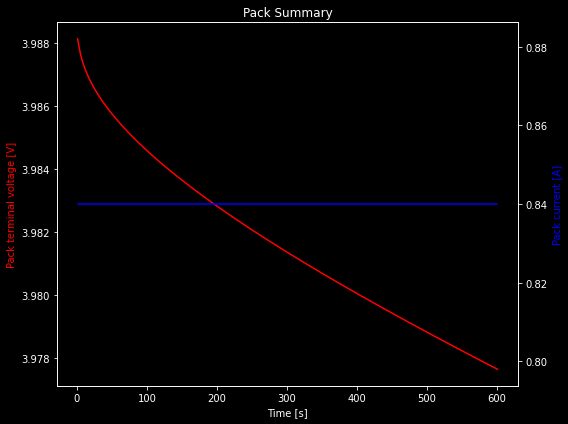

In [13]:
lp.plot_pack(output_m)

In [14]:
def compare(out1, out2):
    # Get pack level results
    time = out1["Time [s]"]
    v_pack = out1["Pack terminal voltage [V]"]
    i_pack = out1["Pack current [A]"]
    v_batt = out2["Pack terminal voltage [V]"]
    i_batt = out2["Pack current [A]"]

    # Plot pack voltage and current
    _, (axl, axr) = plt.subplots(
        1, 2, tight_layout=True, figsize=(15, 10), sharex=True, sharey=True
    )
    axl.plot(time, v_pack, color="green", label="simulation")
    axl.set_xlabel("Time [s]")
    axl.set_ylabel("Pack terminal voltage [V]", color="green")
    axl2 = axl.twinx()
    axl2.plot(time, i_pack, color="black", label="simulation")
    axl2.set_ylabel("Pack current [A]", color="black")
    axl2.set_title("Drive Cycle")
    axr.plot(time, v_batt, color="red", label="simulation")
    axr.set_xlabel("Time [s]")
    axr.set_ylabel("Battery terminal voltage [V]", color="red")
    axr2 = axr.twinx()
    axr2.plot(time, i_batt, color="blue", label="simulation")
    axr2.set_ylabel("Battery current [A]", color="blue")
    axr2.set_title("Mean Current")

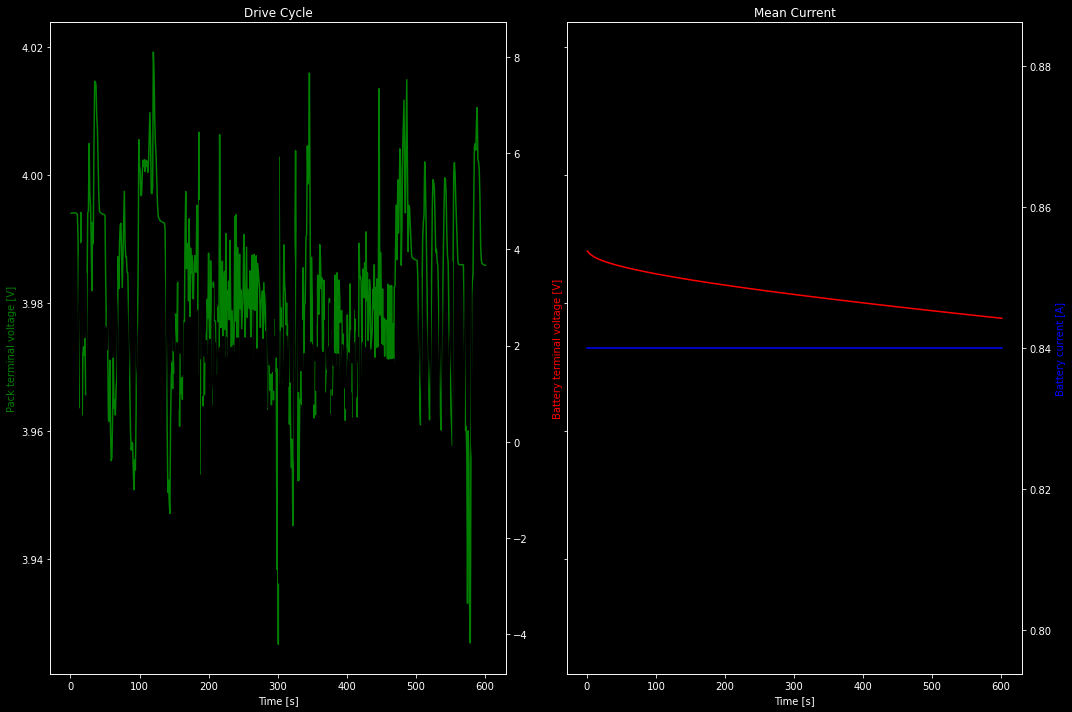

In [15]:
compare(output_d, output_m)

Let's see what happens when we change the period to 1 minute

In [16]:
experiment = pybamm.Experiment(
    operating_conditions=["Run US06 (A)"],
    drive_cycles={"US06": drive_cycle},
    period="1 minute",
)

In [17]:
# Solve pack
output_t = lp.solve(
    netlist=netlist,
    parameter_values=parameter_values,
    experiment=experiment,
    initial_soc=0.75,
)

Stepping simulation: 100%|████████████████████████████████████████████████████████████| 601/601 [00:06<00:00, 93.84it/s]


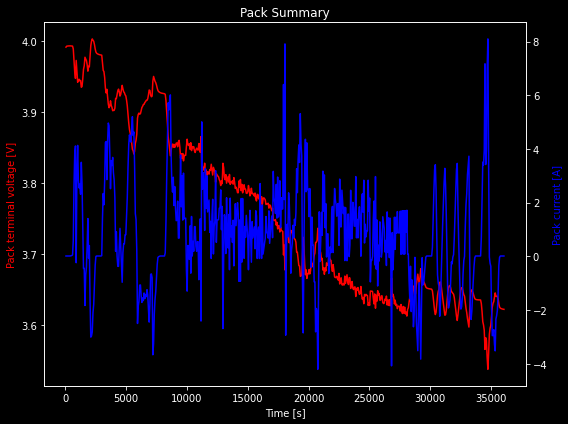

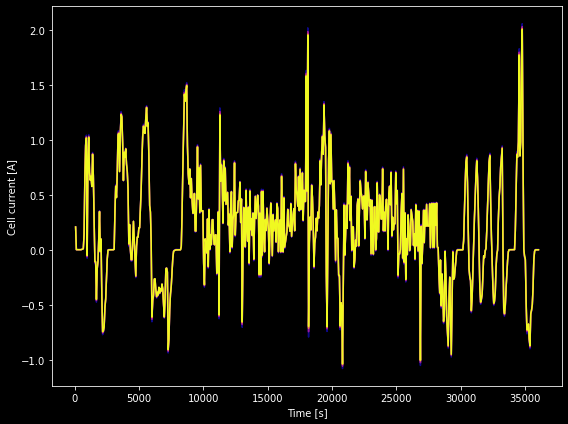

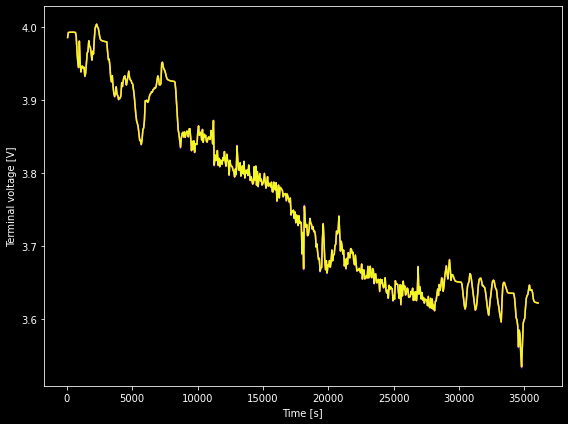

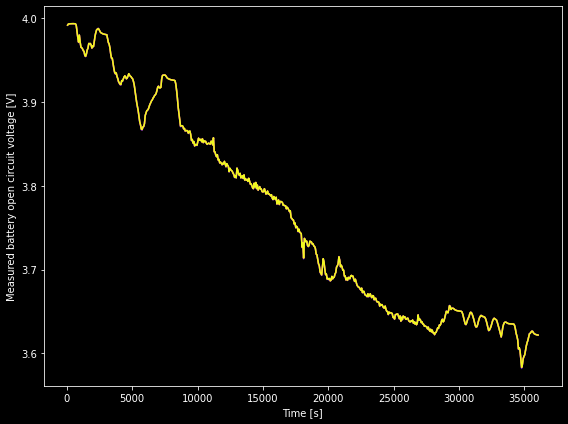

In [18]:
lp.plot_output(output_t)

The drive cycle units in time are modified by the experiment period